# Chapter 2 - Accessing the Dataset

- 
This notebook shows how to

2.1 Understanding the Dataset
4.2 visualize cell metrics in various ways
4.3 create a smaller dataset by selecting cells (rows) from the main dataset
4.4 perform simple statistical analyses on these metric data

#### Assets 

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nbvv
from upath import UPath as Path
from aicsimageio import AICSImage
from ome_zarr.reader import Reader
from ome_zarr.io import parse_url
import logging
logging.getLogger("bfio").setLevel(logging.ERROR)
logging.getLogger("aicsimageio").setLevel(logging.ERROR)


def read_ome_zarr(path, level=0, image_name="default"):
    path = str(path if image_name is None else Path(path) / image_name)
    reader = Reader(parse_url(path))

    node = next(iter(reader()))
    pps = node.metadata["coordinateTransformations"][0][0]["scale"][-3:]
   
    return AICSImage(
        node.data[level].compute(),
        channel_names=node.metadata["name"],
        physical_pixel_sizes=pps
    )

def rescale_image(img_data, channels):
    img_data = img_data.squeeze().astype(np.float32)
    
    for ix, channel in enumerate(channels):
        if "_seg" not in channel:
            img_data[ix] -= 1
            
            img_data[ix] = np.where(
                img_data[ix] >= 0,
                img_data[ix] / img_data.max(),
                -1
            )
    return img_data.astype(np.float16)


ModuleNotFoundError: No module named 'ome_zarr'

In [2]:
df = pd.read_parquet("s3://variance-dataset/processed/manifest.parquet")

#### Jupyter Notebook Help

In [ ]:
# Linke to jupyter notebook website

#### Python Pandas Resources

In [ ]:
# link to python pandas resources

## Chapter 2.1 Understanding the Dataset

### The hiPSC Single-Cell Image Dataset
Our dataset consists of 3D live-cell images of *normal human induced pluripotent stem cells (hiPSCs)*, which are a useful human cell model system. The dataset includes 25 cell lines representing fluorescently tagged major organelles, cellular structures, and compartments. Images of these cells were obtained in 3D using spinning-disk confocal microscopes and were further processed using deep learning-based segmentation. For the Purpose of this hackathon this Dataset has been filtered down to 214037 cells.

<img src="resources/hipsc_single_cell_image_dataset_summary.png"/>

### From FOVs to single-cell images
The hiPSC Single-Cell Image dataset consists of **215,081** single-cell images which were extracted from **18,100** fields of view (FOVs) of our cell colonies. Each row of the dataframe represents a cell, while the columns contain metadata, metrics, imaging data, etc...

In [7]:
# Breif Pre-Processing Description
# NAns for shapemodes
# outliers removed


In [ ]:
# Some Visualizations of the dataset

In [2]:
import plotly.express as px # need to get this to the top
df = pd.read_parquet("resources/hackathon_manifest_092022.parquet")
df.set_index(df['cell metadata']['CellId'].astype(int), inplace=True)
df_filt = df.copy()
df_filt.columns = df_filt.columns.droplevel(0)

The cell images came from over 18K FOVs and we can use the manifest to understand how many FOV's were captured per tagged structure.

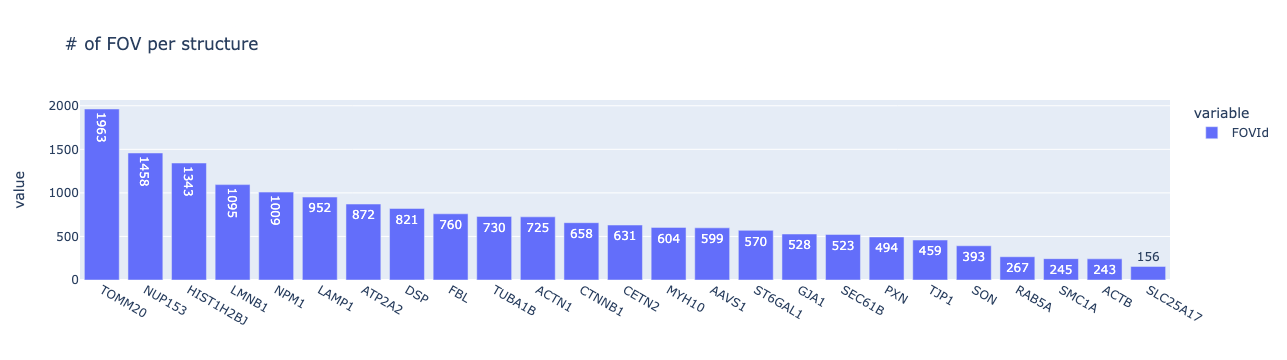

In [45]:
fig_fovstruc = px.bar(df_filt.groupby(['gene']).FOVId.nunique(),text_auto=True,title="# of FOV per structure")
fig_fovstruc.update_layout(xaxis=dict(categoryorder="total descending"),overwrite=True)
fig_fovstruc.show()

The number of FOVs isn't evenly distributed between the cell lines. In addition, the number of cells in an FOV varies based on position of the colony as well as the confluence of the wells. We can visualize the distribution of cells per FOV using a violin plot. We can parse the dataframe to calculate the number of cells per FOVId grouped by structure and then merge these counts into a new data frame for easy access later. Then wecan visualize using a violin plot.

In [46]:
cells_per_fov = (
    df_filt.groupby('gene').FOVId
    .value_counts()
    .to_frame(name="cell_count_per_FOV")
    .reset_index()
    .set_index('FOVId')
    .merge(
        df_filt[['FOVId']]
        .drop_duplicates(subset=['FOVId'])
        .set_index('FOVId'),
        left_index=True,
        right_index=True
    )
    .reset_index()
)

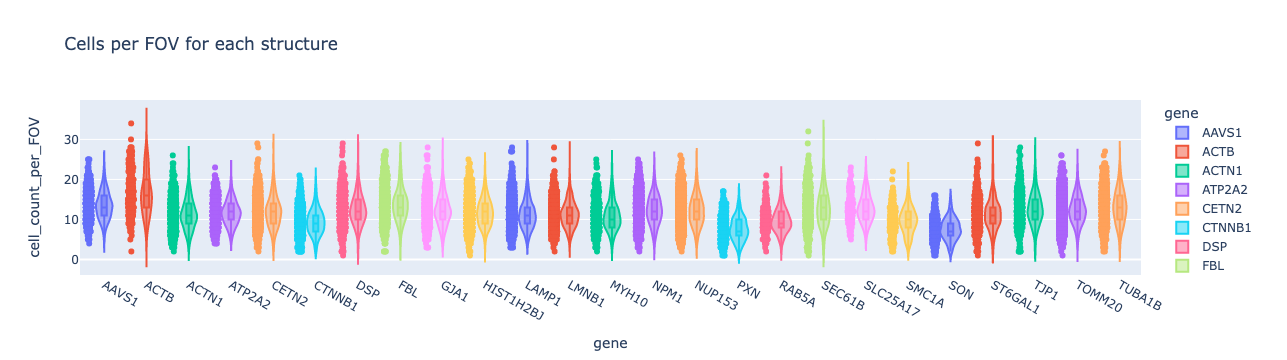

In [49]:
fig_cells_fov = px.violin(
    cells_per_fov,
    x=cells_per_fov.gene,
    y=cells_per_fov.cell_count_per_FOV,
    box=True,
    points='all',
    color=cells_per_fov.gene,
    hover_data=cells_per_fov,
    title="Cells per FOV for each structure"
)
fig_cells_fov.show()

Visualizing the data we can see that overall the distribution of the number of cells is consistent through the different cell lines. We can see that it FOV's generally contain between 2 and 20+ cells with a median around 14.  Though the FOV data is not included for the purposes of this task we can still visualize the FOVs as they are publically available data.  First we'll create a simple function that uses the FOVId to identify a Cell ID which we can use in our browser based cell viewer.

In [32]:
def generate_url(FOV_of_interest):
    cell_id = df[df['FOVId']==FOV_of_interest].CellId.tolist()[0]
    print(f"Click this link https://allen-cell-animated.github.io/website-3d-cell-viewer/?dataset=aics_hipsc_v2021.1&id={FOV_of_interest} and select the Full Field at the top of the screen")

We can hover the data from the violin plot above and select the highest point within the **ACTB** scatter plot and see that the **FOVID is 5785**. We'll use this to look at an FOV with 34 cells! 

In [33]:
FOV_of_interest = 5785 # CHANGE ME -  Enter FOV of interest in this case 5785 which comes from the max number of cells of of ACTB
generate_url(FOV_of_interest)

Click this link https://allen-cell-animated.github.io/website-3d-cell-viewer/?dataset=aics_hipsc_v2021.1&id=5785 and select the Full Field at the top of the screen


The dataset consists of over 200K cells and based on the number distribution of FOVs we can assume that they are not evenly spraed across the 25 cell lines. We can visualize the number of cells per structure by further parsing the data frame.

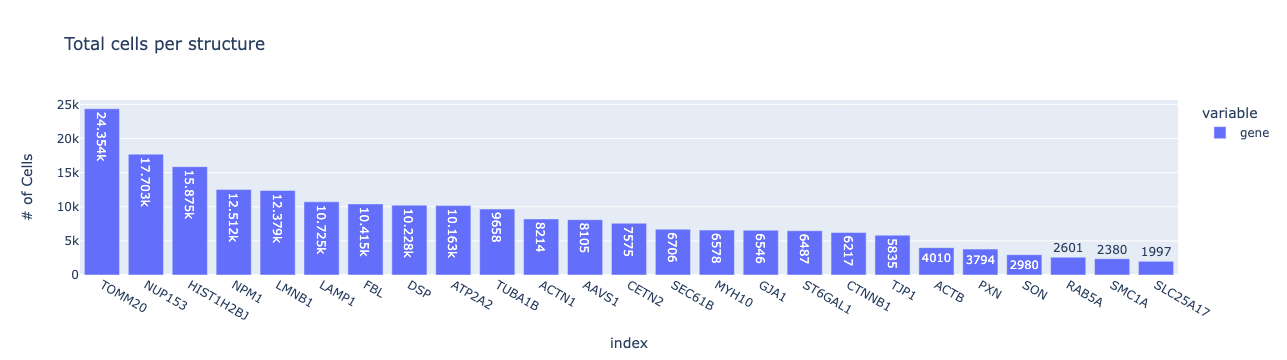

In [50]:
fig_total = px.bar(df_filt.gene.value_counts(),text_auto=True,title="Total cells per structure",labels=dict(value="# of Cells"))
fig_total.show()

## Chapter 2.2 Sub-Datasets

### Dataset Catagories

The dataset columns have been broken down into 4 Catagories [`cell metadata`, `field-of-view metadata`,`cell metrics`,`cell images`]. These catagories are recognized as a secondary header.

cell metadata:
field-of-view metadata:
cell metrics:
cell images: 




In [68]:
df.head()

Category cell metric                                                         \
               angle bbox_max_x bbox_max_y bbox_max_z bbox_min_x bbox_min_y   
0         -86.508019      252.0      247.0      114.0       39.0       49.0   
1           5.235116      308.0      271.0       96.0       73.0       57.0   
2         -60.156382      361.0      274.0      103.0       86.0      135.0   
3          82.318691      272.0      215.0      105.0       51.0       62.0   
4          -3.020769      274.0      197.0      108.0       42.0       57.0   

Category                                  cell metadata  ...      cell metric  \
         bbox_min_z bf_clip_hi bf_clip_lo    cell_stage  ... structure_volume   
0              10.0    46104.0    32994.0          M4M5  ...         195930.0   
1               6.0    44990.0    34108.0            M0  ...         116763.0   
2              15.0    45393.0    33473.0            M0  ...          70647.0   
3               9.0    45295.0    33806.0   M6M7_single  ...          88514.0   
4               9.0    45120.0    34334.0            M0  ...         113858.0   

Category cell metadata       cell images       cell metric cell metadata  \
             Structure structure_clip_hi structure_clip_lo          gene   
0         mitochondria             514.0             407.0        TOMM20   
1         mitochondria             527.0             405.0        TOMM20   
2         mitochondria             546.0             411.0        TOMM20   
3         mitochondria             507.0             410.0        TOMM20   
4         mitochondria             547.0             409.0        TOMM20   

Category                                         \
         this_cell_index this_cell_nbr_complete   
0                    1.0                    1.0   
1                    5.0                    1.0   
2                    6.0                    0.0   
3                    8.0                    0.0   
4                   14.0                    0.0   

Category                                        cell metric  \
                                      this_cell_nbr_dist_2d   
0         [(230745, 112.01229336146552), (230746, 158.51...   
1         [(230741, 112.01229336146552), (230746, 187.55...   
2         [(230741, 158.5175782133776), (230745, 187.555...   
3         [(230741, 115.43538034418327), (230745, 193.90...   
4         [(230757, 195.03496287454146), (230758, 101.72...   

Category field-of-view metadata                  
                         WellId      WorkflowId  
0                       24822.0  ['Pipeline 4']  
1                       24822.0  ['Pipeline 4']  
2                       24822.0  ['Pipeline 4']  
3                       24822.0  ['Pipeline 4']  
4                       24822.0  ['Pipeline 4']  

[5 rows x 78 columns]

### Creating Sub-Datasets

By Catagory

Lets get all columns relating to cell metadata


In [79]:
df.xs('cell metadata', level=0,axis=1)

,cell_stage,CellId,Cellular Component,Description (from Uniprot),Draft mitotic state resolved,edge_flag,Protein,Structure,gene,this_cell_index,this_cell_nbr_complete
CellId,,,,,,,,,,,
230741,M4M5,230741.0,cytoplasm,Central component of the receptor complex resp...,None,0.0,Tom20,mitochondria,TOMM20,1.0,1.0
230745,M0,230745.0,cytoplasm,Central component of the receptor complex resp...,None,0.0,Tom20,mitochondria,TOMM20,5.0,1.0
230746,M0,230746.0,cytoplasm,Central component of the receptor complex resp...,M0,0.0,Tom20,mitochondria,TOMM20,6.0,0.0
230748,M6M7_single,230748.0,cytoplasm,Central component of the receptor complex resp...,M6/M7,0.0,Tom20,mitochondria,TOMM20,8.0,0.0
230754,M0,230754.0,cytoplasm,Central component of the receptor complex resp...,None,0.0,Tom20,mitochondria,TOMM20,14.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1003740,M0,1003740.0,nucleus,Involved in chromosome cohesion during cell cy...,None,0.0,SMC-1A,cohesins,SMC1A,13.0,0.0
1003741,M0,1003741.0,nucleus,Involved in chromosome cohesion during cell cy...,None,0.0,SMC-1A,cohesins,SMC1A,14.0,0.0
1003742,M0,1003742.0,nucleus,Involved in chromosome cohesion during cell cy...,None,0.0,SMC-1A,cohesins,SMC1A,15.0,0.0


# By Columns

Lets get a specific list of columns. angle and structure
# visual angle by structure

In [3]:
lst = ['angle','gene']

In [13]:
(sub_angle_struc['angle']<0)

CellId
230741     False
230745     False
230746     False
230748     False
230754     False
           ...  
1003740    False
1003741    False
1003742    False
1003743    False
1003748    False
Name: angle, Length: 214037, dtype: bool

In [5]:
sub_angle_struc = df_filt[lst]
# get the mean
sub_angle_struc['angle'] = sub_angle_struc['angle'].abs()

/tmp/ipykernel_1478/839303185.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_angle_struc['angle'] = sub_angle_struc['angle'].abs()


In [117]:

df_mean = sub_angle_struc.groupby("gene").abs.mean()

AttributeError: 'DataFrameGroupBy' object has no attribute 'abs'

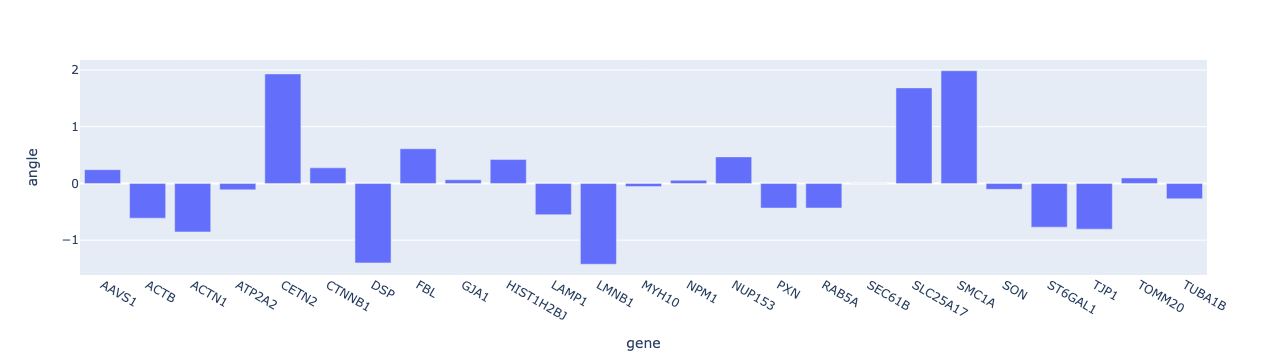

In [115]:
px.bar(df_mean,x=df_mean.index, y='angle')

## Chapter 2.3 Interacting with the Dataset

In [ ]:
# Querying

In [6]:
# Grouping

## Chapter 2.4 Column Descriptions


The dataset contains over 1200 columns with important metrics which you may want to incorporate during the challenge. We have filtered this list of columns to 87 of which we think will be important to your efforts. In this section we'll create a tiny dash app that runs within the notebook in order to display an interactive table of the columns and their descriptions. **The table is searchable** lending itself to more efficient querying.

In [8]:
from jupyter_dash import JupyterDash
import dash
from dash import dcc
from dash import html
JupyterDash.infer_jupyter_proxy_config()

ModuleNotFoundError: No module named 'jupyter_dash'

In [ ]:
col_df = pd.read_csv("resources/colname_test.csv",delimiter=":",header=None)
col_df.columns = ["column name","description"]

In [5]:
# Some sort of Look up method built in for looking at column definitions 
from dash import dash_table
app = JupyterDash(__name__)
server = app.server

app.layout = dash_table.DataTable(
    col_df.to_dict('records'), 
    [{"name": i, "id": i} for i in col_df.columns],
    style_data={
        'whiteSpace':'normal',
        'height': 'auto',
        'lineHeight':'15px',
        'backgroundColor': 'rgb(50,50,50)',
        'color': 'white',
    },
    style_header={
        'backgroundColor':'rgb(30,30,30)',
        'color':'white'
    },  
    style_cell={
        'textAlign':'left'
    },
    filter_action="native",
)


In [ ]:
app.run_server(mode="inline", port=8588,) # This runs on a specified port. Either enable port forwarding on your maching. #TODO work with Gui to enable this directly from the app rather than port forwarding. 